In [28]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('Set3')
import numpy as np
from warnings import filterwarnings
filterwarnings(action="ignore")
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
# Wrangle/pre-process the data
def wrangle(dataset):
# Read data into memory
    data = pd.read_csv(dataset)

#1) Bin the data 
    data["Age_dist"] = pd.cut(data["Age"], bins=[0,1,10,20,30,40,50,60,70,80,], labels=["1", "2", "3", "4", "5", "6", "7", "8", "9"])

    data["Age_dist"].fillna(method="ffill", inplace=True)
    data["Smoking_history"].replace("ever", "never", inplace=True)
    data["Gender"].replace("Other", "Male", inplace=True)
    data["BMI"] = np.log(data["BMI"])
#2) A stratified Shuffle Split    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data, data["Age_dist"]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    strat_train_set.drop("Age_dist", axis = 1, inplace=True)
    strat_test_set.drop("Age_dist", axis = 1, inplace=True)

# Create training and test sets
    train, test = strat_train_set, strat_test_set

# 3) Create Feature matrices and target vectors
    X_test, X_train = test.drop('Diabetes', axis=1), train.drop('Diabetes', axis=1)
    y_test, y_train = test["Diabetes"], train["Diabetes"]

    return {'X_train': X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}





def pipeline(df):
# 1) Further preprocessing
    order_smoke = ['never', 'No Info', 'former', 'not current','current']
    df_continuous = ["Age", "BMI", "HbA1c_level", "Blood_glucose_level"]
    df_multi_discrete = ["Smoking_history"]
    df_single_discrete = ["Gender"]
    
# (2) Create necessary pipelines
    continuous_pipeline = Pipeline(
        [
            ('std_scaler', StandardScaler())
        ])
    multi_discrete_pipeline = Pipeline(
        [
            ("ordinal_encoder", OrdinalEncoder(categories=[order_smoke]))
        ])
    single_discrete_pipeline = Pipeline(
        [
            ("one_hot", OneHotEncoder())
        ])
    
    full_pipeline = ColumnTransformer(
        [
            ("continuous", continuous_pipeline, df_continuous),
            ("multi_discrete", multi_discrete_pipeline, df_multi_discrete),
            ("single_discrete", single_discrete_pipeline, df_single_discrete)
        ],
        remainder="passthrough"
    )
    pipeline = Pipeline(
        steps = [
            ('preprocessor', full_pipeline)
        ]
    )
    transformed_data = pipeline.fit_transform(df)
    c_t = pipeline.named_steps["preprocessor"]
                   
    output = {"td":transformed_data, "c_t":c_t}
    return output



##### The two functions above preprocess the data in various steps:
##### - (1) The first function bins the data on the basis of the age of the patients. This is due to a significant portion of the patients being of the 

age 80. (2) A Stratified shuffle split,(as opposed to a random split), is carried out to preserve the integrity of patient age distributions and 

observations. This is due to the relatively high correlative value of age with other features in the dataset(See Correlation Matrix). (3) The training and test sets are created, along with target values, and then returned in dictionary form.

##### - (1) The features are then treated and preprocessed for passing through the relevant pipelines. Categorical Features are encoded as 
appropriate, continuous features are scaled, and the final pipeline's details are stored to enable extraction of feature names.

In [3]:
data = wrangle("diabetes_prediction_dataset.csv")

In [4]:
df_Xtrain, df_Xtest, df_ytrain, df_ytest  = data["X_train"], data["X_test"], data["y_train"], data["y_test"]

In [5]:
X_train, y_train, X_test, y_test = pipeline(df_Xtrain)["td"], data["y_train"], pipeline(df_Xtest)["td"], data["y_test"]

In [6]:
def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)
    
    return feature_names

feature_names = get_feature_names(pipeline(df_Xtrain)["c_t"])
feature_names[-1], feature_names[-2] = "Heart_disease", "Hypertension"
print(feature_names)


['Age', 'BMI', 'HbA1c_level', 'Blood_glucose_level', 'Smoking_history', 'Gender_Female', 'Gender_Male', 'Hypertension', 'Heart_disease']


In [7]:
log_model = LogisticRegression(random_state=42, C=2)
log_model.fit(X_train, y_train)
test_pred = log_model.predict(X_test)
train_pred = log_model.predict(X_train)
print(f"Accuracy Score(Training):\t{accuracy_score(y_train, train_pred)}")
print(f"Accuracy Score(Test):\t{accuracy_score(y_test, test_pred)}")
print(classification_report(y_test, test_pred))
print(f"Precision Score: {precision_score(y_test, test_pred)}")
print(f"Recall Score: {recall_score(y_test, test_pred)}")
print(f"F1 Score: {f1_score(y_test, test_pred)}")
print(f"ROC Score: {roc_auc_score(y_test, test_pred)}")

Accuracy Score(Training):	0.9606375
Accuracy Score(Test):	0.959
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18292
           1       0.87      0.61      0.72      1708

    accuracy                           0.96     20000
   macro avg       0.92      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000

Precision Score: 0.8675496688741722
Recall Score: 0.6135831381733021
F1 Score: 0.7187928669410152
ROC Score: 0.802418072476111


In [8]:
SVC_model = SVC(random_state=42, C=0.5)
SVC_model.fit(X_train, y_train)
SVC_test_pred = SVC_model.predict(X_test)
SVC_train_pred = SVC_model.predict(X_train)
print(f"Accuracy Score(Training):\t{accuracy_score(y_train, SVC_train_pred)}")
print(f"Accuracy Score(Test):\t{accuracy_score(y_test, SVC_test_pred)}")
print(classification_report(y_test, SVC_test_pred))
print(f"Precision Score: {precision_score(y_test, SVC_test_pred)}")
print(f"Recall Score: {recall_score(y_test, SVC_test_pred)}")
print(f"F1 Score: {f1_score(y_test, SVC_test_pred)}")
print(f"ROC Score: {roc_auc_score(y_test, SVC_test_pred)}")

Accuracy Score(Training):	0.9644
Accuracy Score(Test):	0.9633
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18292
           1       0.99      0.57      0.73      1708

    accuracy                           0.96     20000
   macro avg       0.98      0.79      0.85     20000
weighted avg       0.96      0.96      0.96     20000

Precision Score: 0.9949186991869918
Recall Score: 0.5731850117096019
F1 Score: 0.7273402674591382
ROC Score: 0.7864558340857215


In [9]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=4)
tree_model.fit(X_train, y_train)
tree_test_pred = tree_model.predict(X_test)
tree_train_pred = tree_model.predict(X_train)
print(f"Accuracy Score(Training):\t{accuracy_score(y_train, tree_train_pred)}")
print(f"Accuracy Score(Test):\t{accuracy_score(y_test, tree_test_pred)}")
print(classification_report(y_test, tree_test_pred))
print(f"Precision Score: {precision_score(y_test, tree_test_pred)}")
print(f"Recall Score: {recall_score(y_test, tree_test_pred)}")
print(f"F1 Score: {f1_score(y_test, tree_test_pred)}")
print(f"ROC Score: {roc_auc_score(y_test, tree_test_pred)}")

Accuracy Score(Training):	0.972025
Accuracy Score(Test):	0.97125
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       1.00      0.66      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Precision Score: 1.0
Recall Score: 0.6633489461358314
F1 Score: 0.797606476592749
ROC Score: 0.8316744730679158


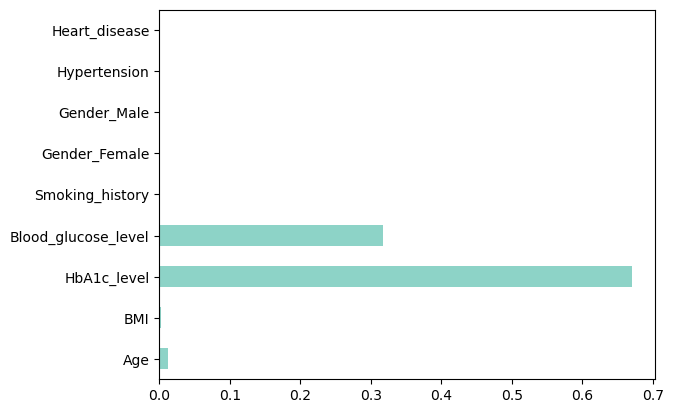

In [10]:
importances = list(tree_model.feature_importances_)
diagram = pd.Series(importances, index=feature_names)
diagram.plot(kind="barh")
plt.savefig("Fig_9.png");

In [11]:
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8], "max_depth":[i for i in range(1, 8)]},
 {'n_estimators': [3, 10], 'max_features': [2, 3, 4],  "max_depth":[i for i in range(1, 8)]},
 ]
forest_reg = RandomForestClassifier(n_jobs=-1, random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
n_jobs= -1,
return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 7, 'max_features': 4, 'n_estimators': 3}

In [12]:
best_model = grid_search.best_estimator_
best_model_test_pred = best_model.predict(X_test)
best_model_train_pred = best_model.predict(X_train)
print(f"Accuracy Score(Training):{accuracy_score(y_train, best_model_train_pred)}")
print(f"Accuracy Score(Test):{accuracy_score(y_test, best_model_test_pred)}")
print(classification_report(y_test, best_model_test_pred))
print(f"Precision Score: {precision_score(y_test, best_model_test_pred)}")
print(f"Recall Score: {recall_score(y_test, best_model_test_pred)}")
print(f"F1 Score: {f1_score(y_test, best_model_test_pred)}")
print(f"ROC Score: {roc_auc_score(y_test, best_model_test_pred)}")

Accuracy Score(Training):0.9720625
Accuracy Score(Test):0.97135
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       1.00      0.67      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Precision Score: 0.9982440737489026
Recall Score: 0.6656908665105387
F1 Score: 0.7987355110642783
ROC Score: 0.8327907645476375


#### Cross validation scores of the best fit model

In [13]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"mean_score: {round(mean_score, 3)}\t : params: {params}")

mean_score: 0.93	 : params: {'max_depth': 1, 'max_features': 2, 'n_estimators': 3}
mean_score: 0.915	 : params: {'max_depth': 1, 'max_features': 2, 'n_estimators': 10}
mean_score: 0.929	 : params: {'max_depth': 1, 'max_features': 2, 'n_estimators': 30}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 4, 'n_estimators': 3}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 4, 'n_estimators': 10}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 4, 'n_estimators': 30}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 6, 'n_estimators': 3}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 6, 'n_estimators': 10}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 6, 'n_estimators': 30}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 8, 'n_estimators': 3}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 8, 'n_estimators': 10}
mean_score: 0.954	 : params: {'max_depth': 1, 'max_features': 8, 'n_es

In [14]:
forest_model = RandomForestClassifier(random_state=42, max_depth=7, n_jobs=-1, n_estimators=3, max_features=8)
forest_model.fit(X_train, y_train)
forest_test_pred = forest_model.predict(X_test)
forest_train_pred = forest_model.predict(X_train)
print(f"Accuracy Score(Training):{accuracy_score(y_train, forest_train_pred)}")
print(f"Accuracy Score(Test):{accuracy_score(y_test, forest_test_pred)}")
print(classification_report(y_test, forest_test_pred))
print(f"Precision Score: {precision_score(y_test, forest_test_pred)}")
print(f"Recall Score: {recall_score(y_test, forest_test_pred)}")
print(f"F1 Score: {f1_score(y_test, forest_test_pred)}")
print(f"ROC Score: {roc_auc_score(y_test, forest_test_pred)}")

Accuracy Score(Training):0.972025
Accuracy Score(Test):0.9712
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.97      0.68      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Precision Score: 0.974036850921273
Recall Score: 0.6809133489461359
F1 Score: 0.8015161957270848
ROC Score: 0.8396093095047759


In [15]:
forest_model = RandomForestClassifier(random_state=42, max_depth=7, n_jobs=-1, n_estimators=3, max_features=4)
forest_model.fit(X_train, y_train)
forest_test_pred = forest_model.predict(X_test)
forest_train_pred = forest_model.predict(X_train)
print(f"Accuracy Score(Training):{accuracy_score(y_train, forest_train_pred)}")
print(f"Accuracy Score(Test):{accuracy_score(y_test, forest_test_pred)}")
print(classification_report(y_test, forest_test_pred))
print(f"Precision Score: {precision_score(y_test, forest_test_pred)}")
print(f"Recall Score: {recall_score(y_test, forest_test_pred)}")
print(f"F1 Score: {f1_score(y_test, forest_test_pred)}")
print(f"ROC Score: {roc_auc_score(y_test, forest_test_pred)}")

Accuracy Score(Training):0.9720625
Accuracy Score(Test):0.97135
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       1.00      0.67      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Precision Score: 0.9982440737489026
Recall Score: 0.6656908665105387
F1 Score: 0.7987355110642783
ROC Score: 0.8327907645476375


In [16]:
fpr, tpr, thresholds = roc_curve(y_train, forest_train_pred)
print(f"FPR: {fpr}")
print(f"TPR: {tpr}")

FPR: [0.00000000e+00 2.73194186e-05 1.00000000e+00]
TPR: [0.         0.67123086 1.        ]


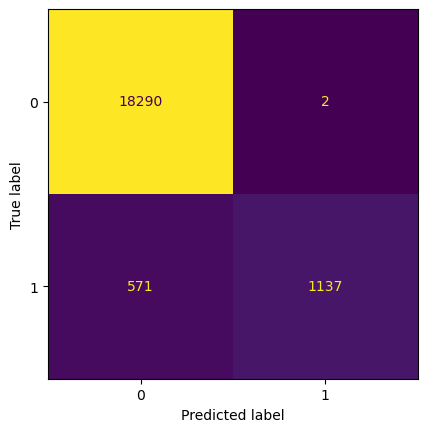

In [17]:
forest_matrix = confusion_matrix(y_test, forest_test_pred)
disp = ConfusionMatrixDisplay(forest_matrix)
disp.plot(colorbar=False);
#plt.savefig("Fig_1000.png");

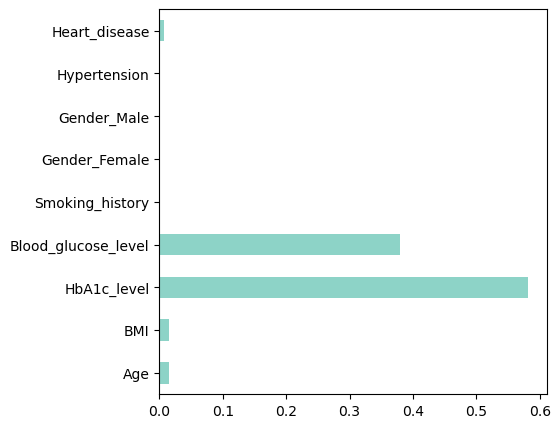

In [20]:
importances = list(forest_model.feature_importances_)
diagram = pd.Series(importances, index=feature_names)
diagram.plot(kind="barh", figsize=(5, 5));
#plt.savefig("Feat_imp.png");